In [1]:
%%html
<link rel="stylesheet" type="text/css" href="css/rise.css" />

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [8, 6]

# Neural Network (NN)

### Learning goals - *Neural Network*
|  |  |  |
|--|--|--|
| <img src="images/thinking-icon.png"> | <div class="alert alert-info">You will be introduced to PyTorch for building and training neural networks.</div> | `e.g.` |

[PyTorch](https://pytorch.org)

`conda install -c pytorch pytorch`

# Linear regression

In [2]:
import pandas as pd

# Meseares of various features and diabetes disease progression for 442 patients.
# Available at https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt
df = pd.read_csv('data/diabetes.csv')
df

,AGE,SEX,BMI,BP,TC,LDL,HDL,TCH,LTG,GLU,DIS
0,59,2,32.1,101.00,157,93.2,38.0,4.00,4.8598,87,151
1,48,1,21.6,87.00,183,103.2,70.0,3.00,3.8918,69,75
2,72,2,30.5,93.00,156,93.6,41.0,4.00,4.6728,85,141
3,24,1,25.3,84.00,198,131.4,40.0,5.00,4.8903,89,206
4,50,1,23.0,101.00,192,125.4,52.0,4.00,4.2905,80,135
...,...,...,...,...,...,...,...,...,...,...,...
437,60,2,28.2,112.00,185,113.8,42.0,4.00,4.9836,93,178
438,47,2,24.9,75.00,225,166.0,42.0,5.00,4.4427,102,104
439,60,2,24.9,99.67,162,106.6,43.0,3.77,4.1271,95,132
440,36,1,30.0,95.00,201,125.2,42.0,4.79,5.1299,85,220


In [3]:
from sklearn.model_selection import train_test_split

X = df.loc[:,'AGE':'GLU'].to_numpy()
y = df.loc[:,'DIS'].to_numpy()

Xs = (X - X.mean(axis=0)) / X.std(axis=0)
ys = (y - y.mean()) / y.std()

X_train, X_test, y_train, y_test = train_test_split(Xs, ys, shuffle=True, test_size=0.2, random_state=1)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((353, 10), (353,), (89, 10), (89,))

In [4]:
from sklearn.linear_model import LinearRegression

LR_model = LinearRegression()
LR_model.fit(X_train, y_train)

LR_train_pred = LR_model.predict(X_train)
LR_test_pred = LR_model.predict(X_test)

LR_train_mse = ((y_train - LR_train_pred)**2).mean()
LR_test_mse = ((y_test - LR_test_pred)**2).mean()

LR_train_mse, LR_test_mse

(0.47809312826669087, 0.5046609304103401)

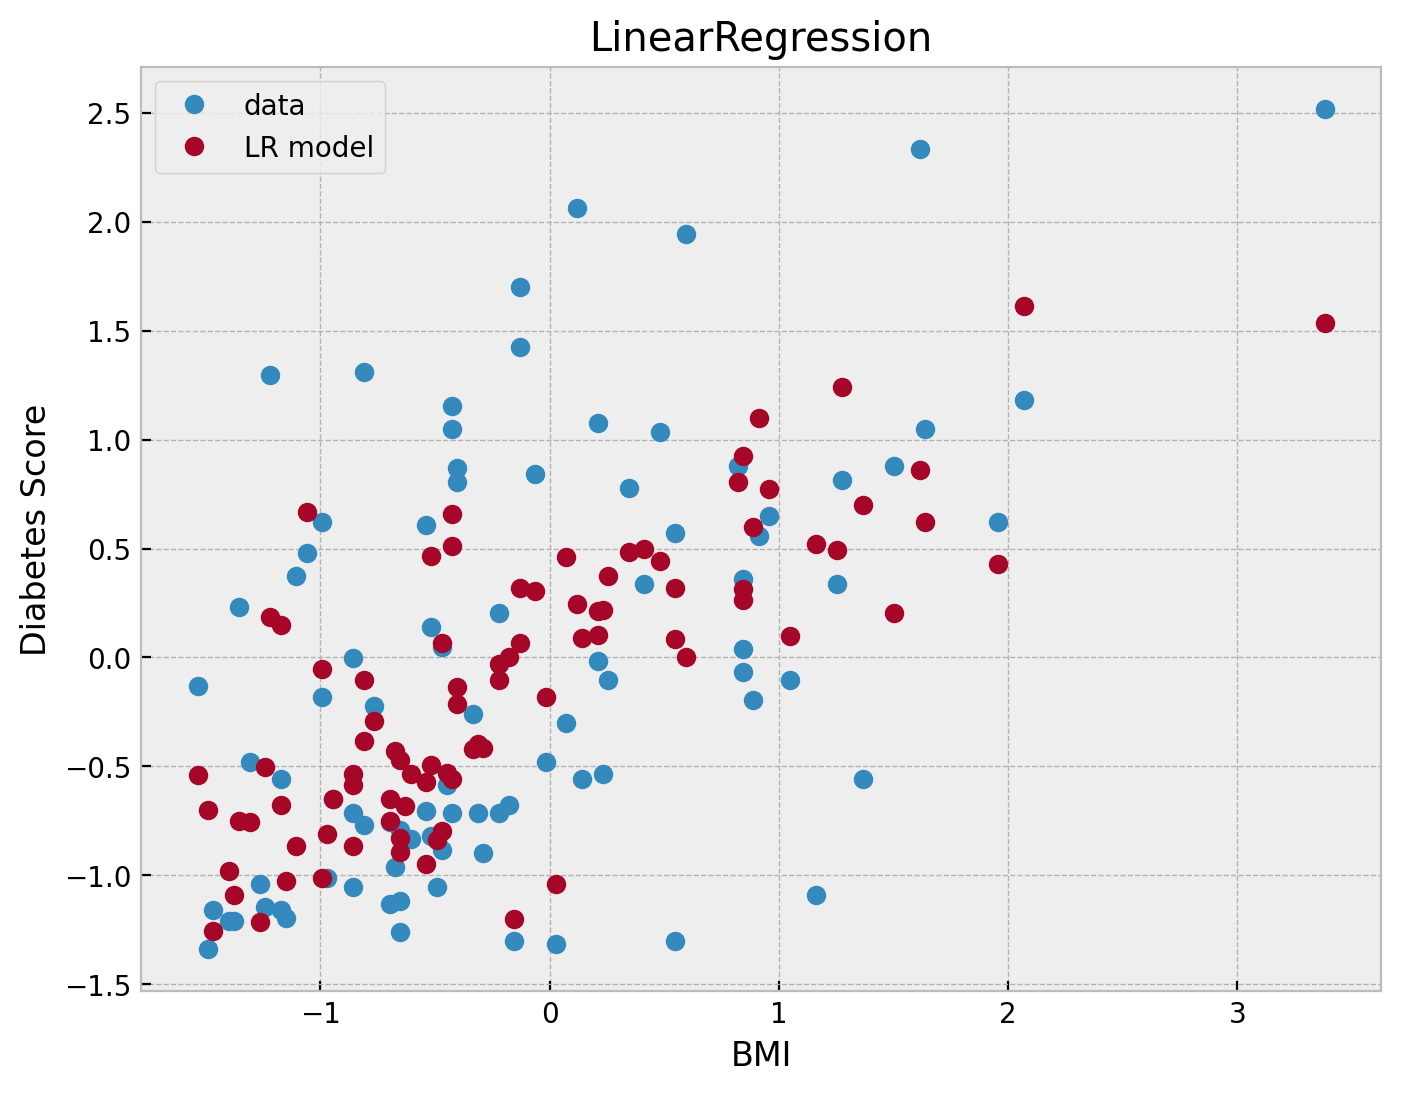

In [5]:
bmi_test = X_test[:,2]

plt.plot(bmi_test, y_test, 'o', label='data')
plt.plot(bmi_test, LR_test_pred, 'o', label='LR model')
plt.xlabel('BMI')
plt.ylabel('Diabetes Score')
plt.title('LinearRegression')
plt.legend();

# Linear regression with PyTorch

In [6]:
import torch

Xt_train = torch.tensor(X_train).float()
yt_train = torch.tensor(y_train.reshape([-1,1])).float()

Xt_test = torch.tensor(X_test).float()
yt_test = torch.tensor(y_test.reshape([-1,1])).float()

Xt_train.shape, yt_train.shape, Xt_test.shape, yt_test.shape

(torch.Size([353, 10]),
 torch.Size([353, 1]),
 torch.Size([89, 10]),
 torch.Size([89, 1]))

In [7]:
from torch import nn

class LinearRegressionNN(nn.Module):
    def __init__(self):
        # initialize the parent class
        nn.Module.__init__(self)

        # define the layers
        self.linear = nn.Linear(10, 1)

    def forward(self, x):
        # define the forward pass through the network
        y = self.linear(x)
        return y

In [8]:
# pseudo-random number generator seed for initializing the weights
torch.manual_seed(1)

# create the model
NN_LR_model = LinearRegressionNN()

10 weights and 1 bias for the 10 features.

In [9]:
NN_LR_model.linear.weight, NN_LR_model.linear.bias

(Parameter containing:
 tensor([[ 0.1629, -0.1396, -0.0613,  0.1484, -0.2977,  0.1896, -0.0651,  0.1609,
           0.0440, -0.0387]], requires_grad=True),
 Parameter containing:
 tensor([0.0877], requires_grad=True))

In [10]:
# loss function
loss_fn = nn.MSELoss()

# stochastic gradient descent optimizer
# lr = learning rate
optimizer = torch.optim.SGD(NN_LR_model.parameters(), lr=1e-2)

In [11]:
def train(model, X, y, loss_fn, optimizer, n_epochs):
    # put model into training mode
    model.train()
    
    train_loss = np.zeros(n_epochs)
    for i in range(n_epochs):
        # Compute prediction error
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # update model parameters (i.e., weights and biases)
        optimizer.step()
        
        # store loss
        train_loss[i] = loss.item()
    
    return train_loss

In [12]:
# for reproducibility
torch.manual_seed(1)

# train the model
NN_LR_train_mse = train(NN_LR_model, Xt_train, yt_train, loss_fn, optimizer, 300)

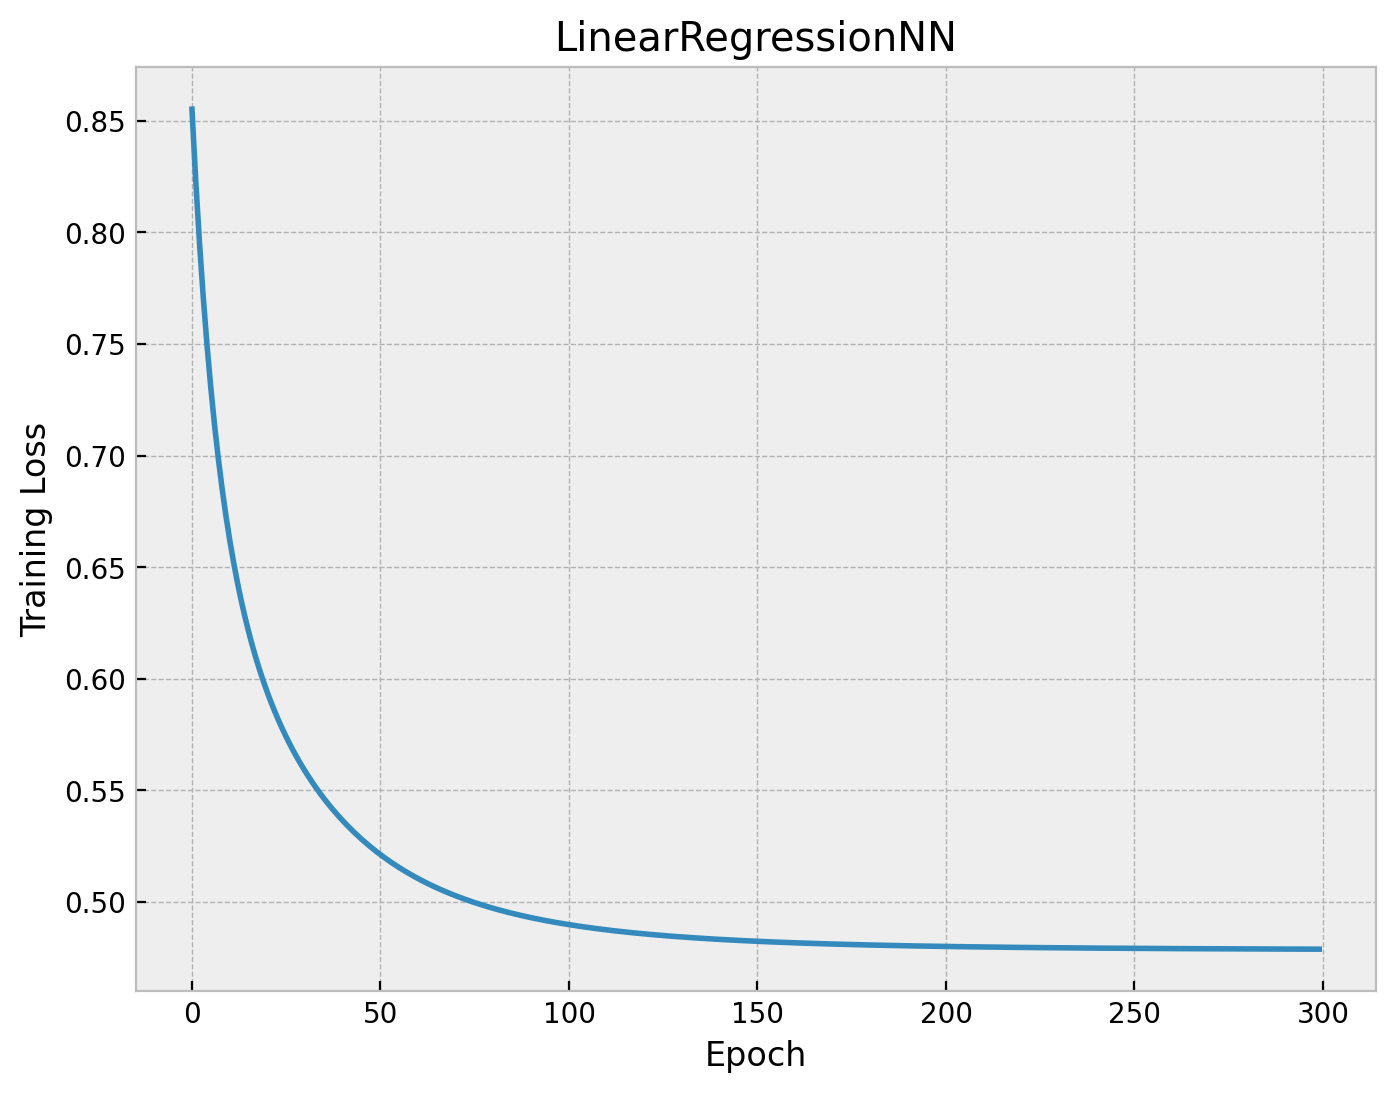

In [13]:
plt.plot(NN_LR_train_mse)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('LinearRegressionNN');

In [14]:
# optimized model parameters
NN_LR_model.linear.weight, NN_LR_model.linear.bias

(Parameter containing:
 tensor([[-0.0146, -0.1776,  0.3212,  0.2112, -0.2602,  0.1070, -0.0451,  0.1198,
           0.3509,  0.0417]], requires_grad=True),
 Parameter containing:
 tensor([-0.0095], requires_grad=True))

In [15]:
def test(model, X, y, loss_fn):
    # put model into testing (evaluation) mode
    model.eval()
    
    with torch.no_grad():
        # torch.no_grad() applied within this block
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        test_loss = loss.item()
    
    return test_loss

In [16]:
# compute test error
NN_LR_test_mse = test(NN_LR_model, Xt_test, yt_test, loss_fn)

NN_LR_train_mse[-1], NN_LR_test_mse

(0.47875893115997314, 0.5081381797790527)

In [17]:
LR_train_mse, LR_test_mse

(0.47809312826669087, 0.5046609304103401)

In [18]:
NN_LR_test_pred = NN_LR_model(Xt_test)

NN_LR_test_pred.shape

torch.Size([89, 1])

In [19]:
NN_LR_test_pred.squeeze().shape

torch.Size([89])

In [20]:
NN_LR_test_pred.squeeze().numpy()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [21]:
NN_LR_test_pred = NN_LR_test_pred.squeeze().detach().numpy()

NN_LR_test_pred.shape

(89,)

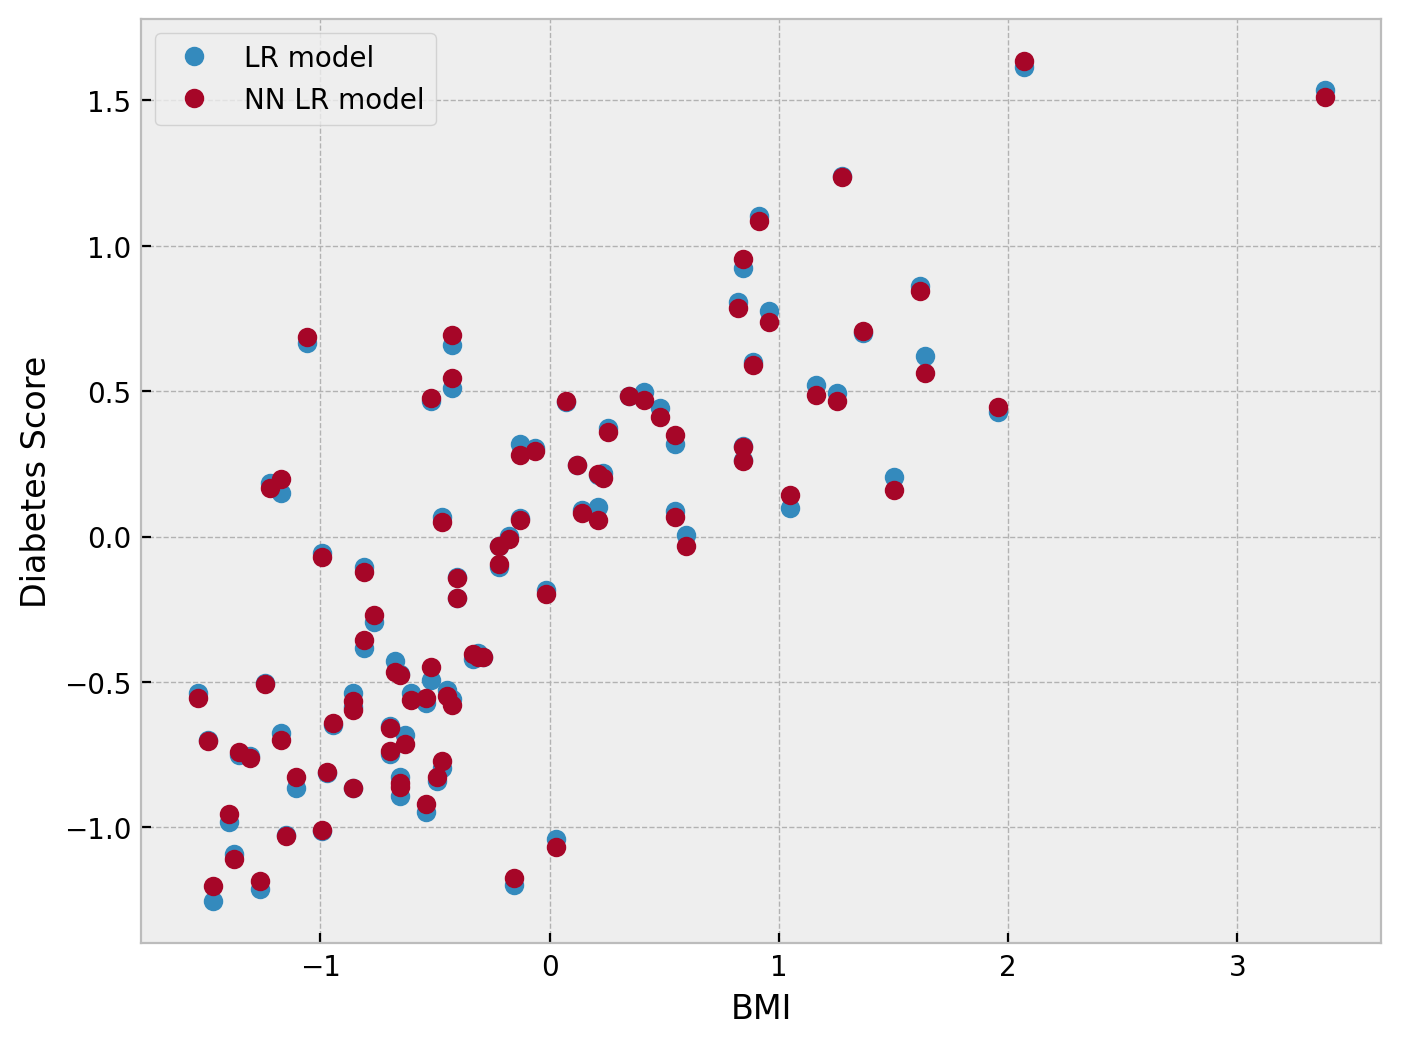

In [22]:
#plt.plot(bmi_test, y_test, 'o', label='data')
plt.plot(bmi_test, LR_test_pred, 'o', label='LR model')
plt.plot(bmi_test, NN_LR_test_pred, 'o', label='NN LR model')
plt.xlabel('BMI')
plt.ylabel('Diabetes Score')
plt.legend();

# L2 Regularization

$loss = loss + \alpha \sum_i w_i^2$

In [23]:
alphas = np.logspace(-2, 0, 20)
test_mse = np.zeros(alphas.shape)
for i, alpha in enumerate(alphas):
    torch.manual_seed(1)
    NN_LR_L2_model = LinearRegressionNN()
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.SGD(NN_LR_L2_model.parameters(), lr=1e-2, weight_decay=alpha)
    NN_LR_L2_train_mse = train(NN_LR_L2_model, Xt_train, yt_train, loss_fn, optimizer, 300)
    test_mse[i] = test(NN_LR_L2_model, Xt_test, yt_test, loss_fn)
alpha = alphas[np.argmin(test_mse)]
alpha

0.18329807108324356

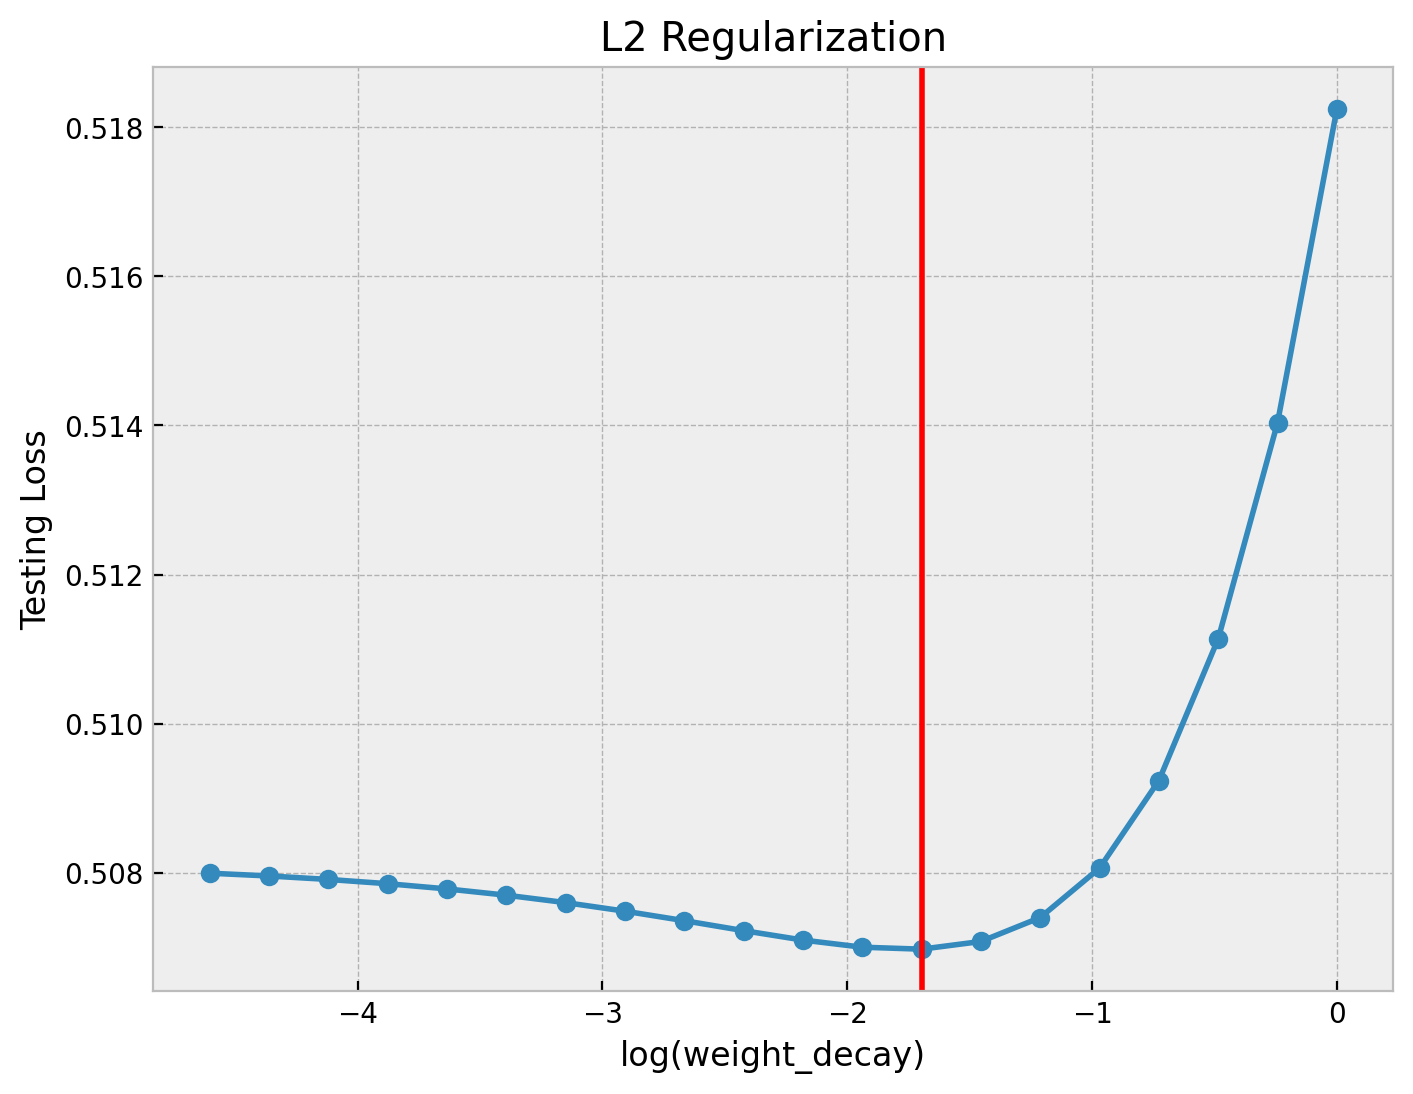

In [25]:
plt.plot(np.log(alphas), test_mse, 'o-')
plt.axvline(np.log(alpha), color='r')
plt.xlabel('log(weight_decay)')
plt.ylabel('Testing Loss')
plt.title('L2 Regularization');

# Moving from the CPU to the GPU

In [75]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    # GPU for MacOS devices with Metal programming framework
    device = "mps"
else:
    device = "cpu"

device

'mps'

Google Colab offers you free online use of GPUs so you can try this out even if you don't have a CUDA compatible NVIDIA GPU.

In [27]:
# create model and move it to the GPU if you have the appropriate hardware
NN_LR_model = LinearRegressionNN().to(device)

CPU and GPU memory don't play together, so if your model exists on the GPU you must also move any data you want it to work with to the GPU as well.

In [28]:
Xt_train = Xt_train.to(device)
yt_train = yt_train.to(device)

Xt_test = Xt_test.to(device)
yt_test = yt_test.to(device)

# Mouse V1 activity in response to gratings of varying orientation

Mouse V1 data from Stringer et al. (2019)
https://www.biorxiv.org/content/10.1101/679324v2.abstract

![](images/grating-mouse.png)

These data comprise time-averaged responses of ~20,000 neurons to ~4,000 stimulus gratings of different orientations from 0-360 degrees, recorded through Calcium imaging. The responses have been normalized by spontaneous levels of activity and then z-scored over stimuli, so expect negative numbers. They have also been binned and averaged to each degree of orientation.

Example from [Neuromatch Academy](https://compneuro.neuromatch.io/tutorials/W2D1_DeepLearning/student/W2D1_Tutorial1.html)

Grating orientations

![](images/grating-orientations.png)

In [30]:
neural_responses = np.load('data/neural_responses.npy')
grating_orientations = np.load('data/grating_orientations.npy')

neural_responses.shape, grating_orientations.shape

((360, 23589), (360,))

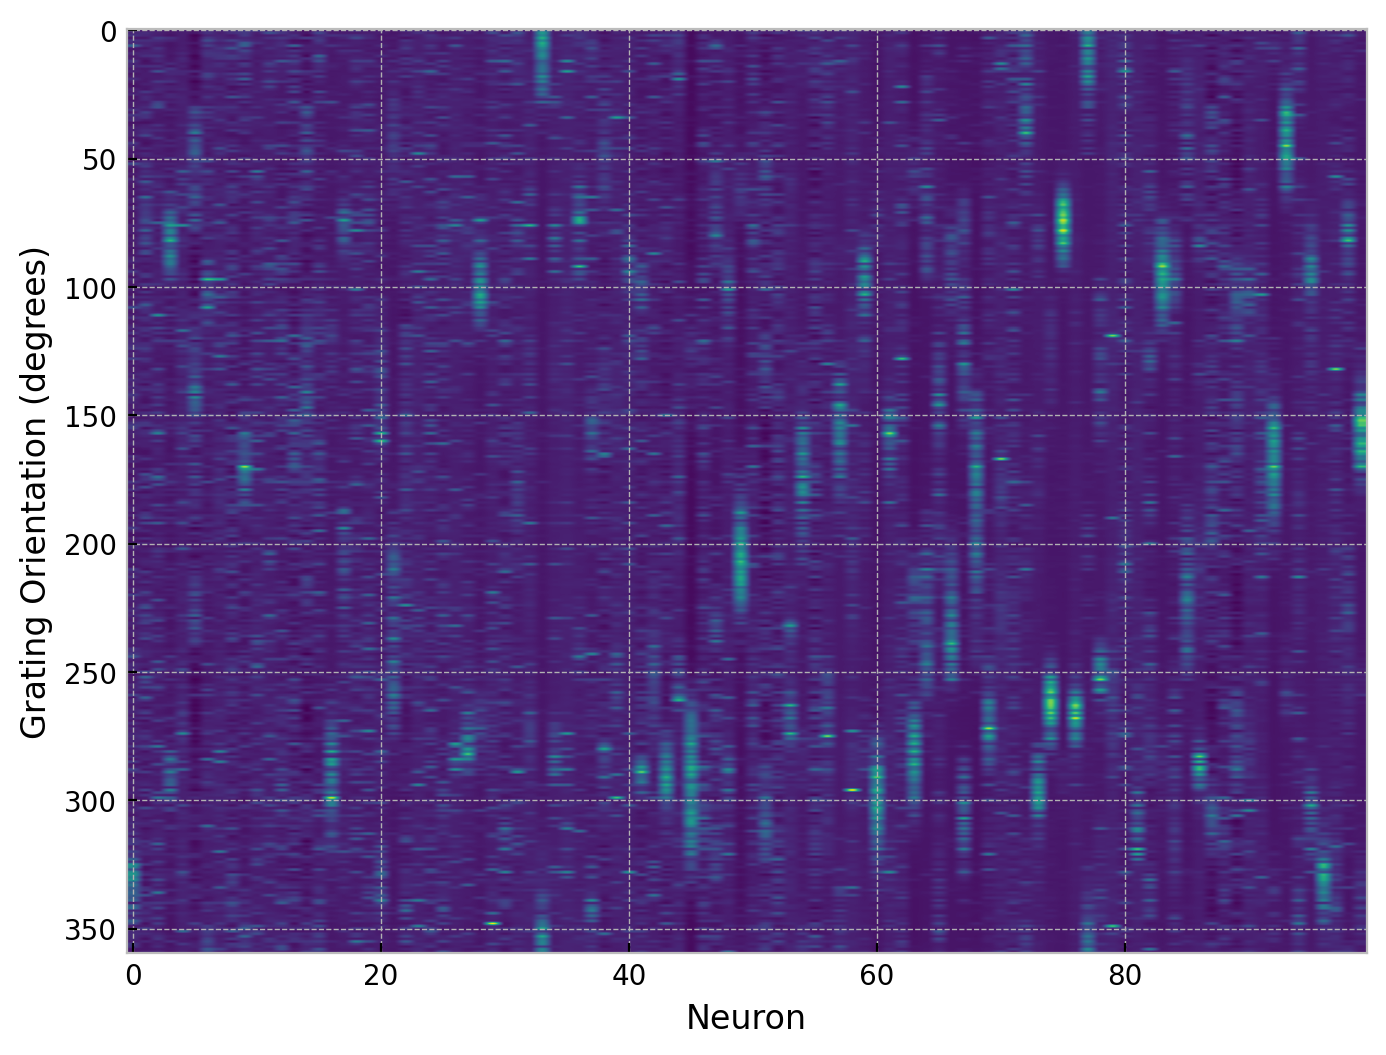

In [31]:
plt.imshow(neural_responses[:,:100], aspect='auto')
plt.xlabel('Neuron')
plt.ylabel('Grating Orientation (degrees)');

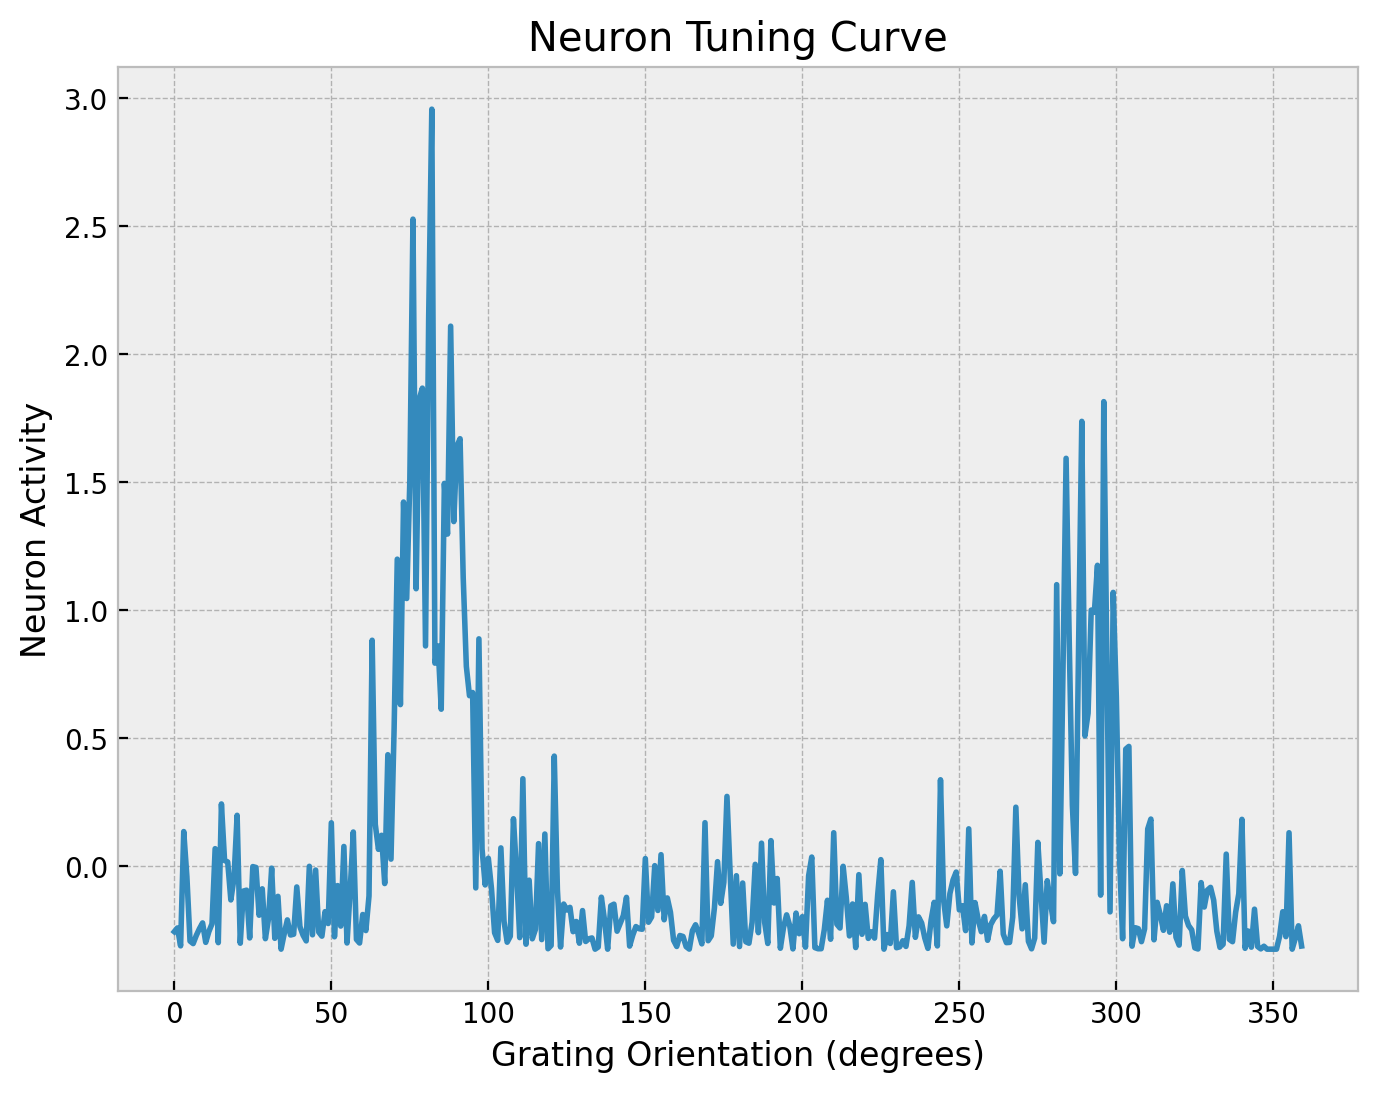

In [32]:
plt.plot(grating_orientations, neural_responses[:,3])
plt.xlabel('Grating Orientation (degrees)')
plt.ylabel('Neuron Activity')
plt.title('Neuron Tuning Curve');

In [33]:
from sklearn.model_selection import train_test_split

X = neural_responses
y = grating_orientations

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.4, random_state=3)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((216, 23589), (216,), (144, 23589), (144,))

In [34]:
Xt = torch.tensor(X).float().to(device)
yt = torch.tensor(y.reshape([-1,1])).float().to(device)

Xt_train = torch.tensor(X_train).float().to(device)
yt_train = torch.tensor(y_train.reshape([-1,1])).float().to(device)

Xt_test = torch.tensor(X_test).float().to(device)
yt_test = torch.tensor(y_test.reshape([-1,1])).float().to(device)

Xt_train.shape, yt_train.shape, Xt_test.shape, yt_test.shape

(torch.Size([216, 23589]),
 torch.Size([216, 1]),
 torch.Size([144, 23589]),
 torch.Size([144, 1]))

In [35]:
class GratingOrientationNet(nn.Module):
    def __init__(self, n_inputs, n_hidden):
        # initialize the parent class
        nn.Module.__init__(self)

        # define the layers
        self.hidden_layer = nn.Linear(n_inputs, n_hidden)
        self.output_layer = nn.Linear(n_hidden, 1)

    def forward(self, x):
        # hidden layer and ReLU activation
        h = torch.relu(self.hidden_layer(x))
        # output layer
        y = self.output_layer(h)
        return y

In [36]:
# for reproducibility
torch.manual_seed(1)

# construct the model with 23589 inputs and 10 hidden units
grating_model = GratingOrientationNet(23589, 10)

In [39]:
# predicted orientation for neural responses associated with gratings at 36 degrees
pred_orientation = grating_model(Xt[36,:])
pred_orientation

tensor([0.1067], grad_fn=<AddBackward0>)

In [41]:
# predicted orientation for neural responses associated with gratings at 90 degrees
pred_orientation = grating_model(Xt[90,:])
pred_orientation

tensor([0.1448], grad_fn=<AddBackward0>)

In [42]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(grating_model.parameters(), lr=1e-4)

train_loss = train(grating_model, Xt_train, yt_train, loss_fn, optimizer, 50)

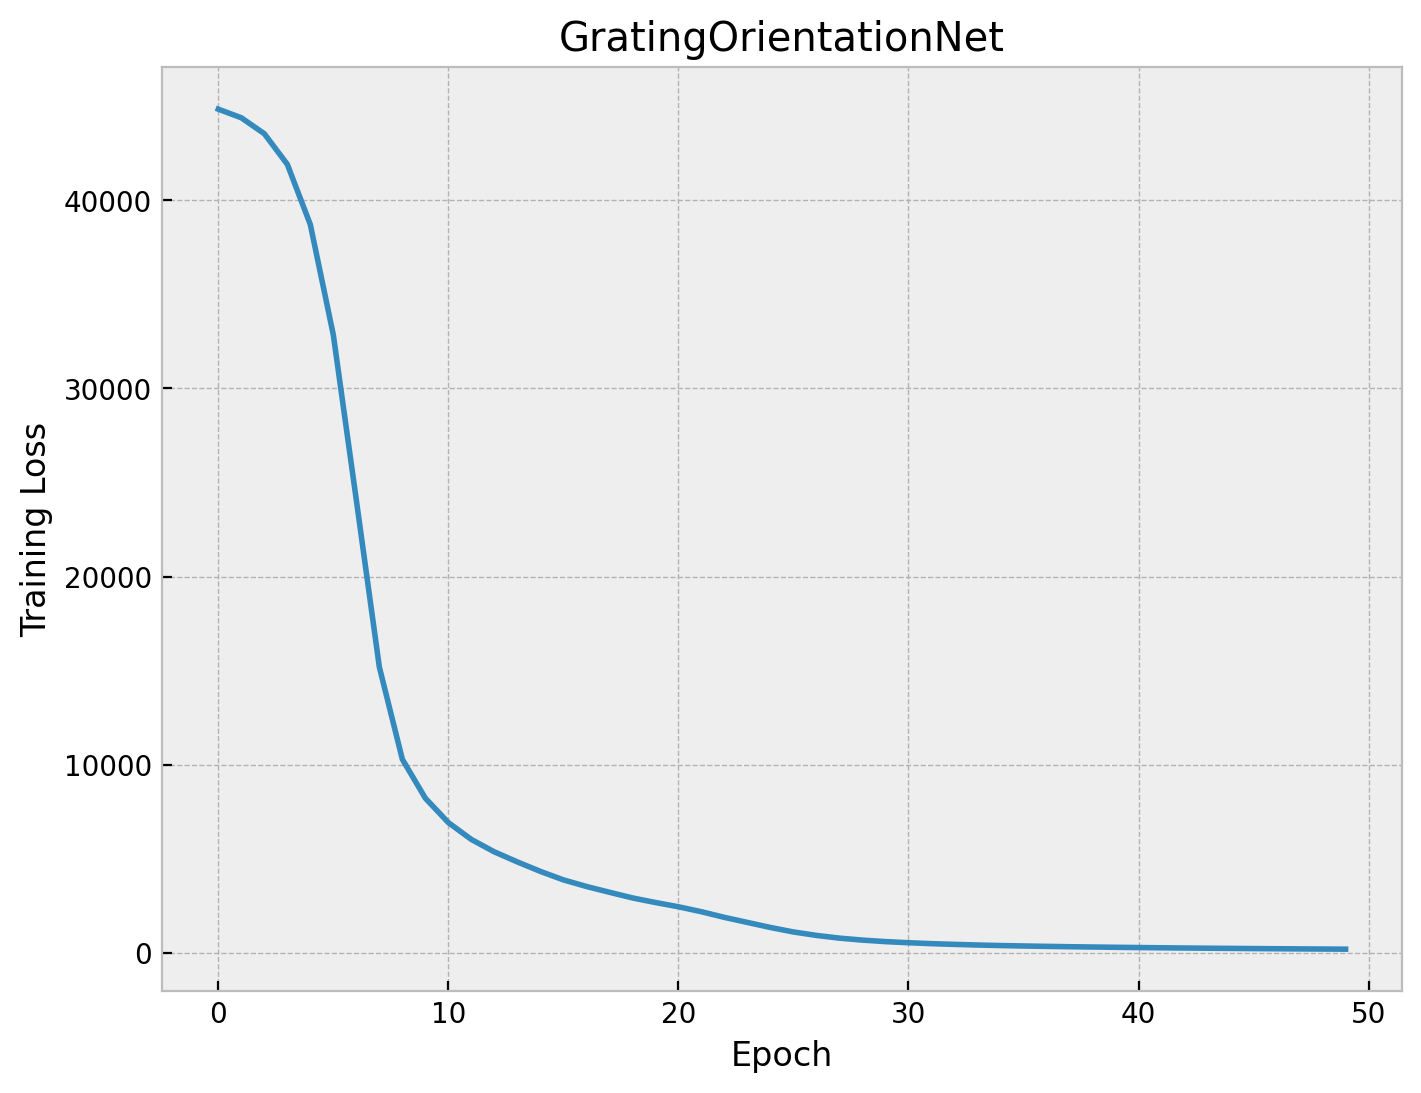

In [43]:
plt.plot(train_loss)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('GratingOrientationNet');

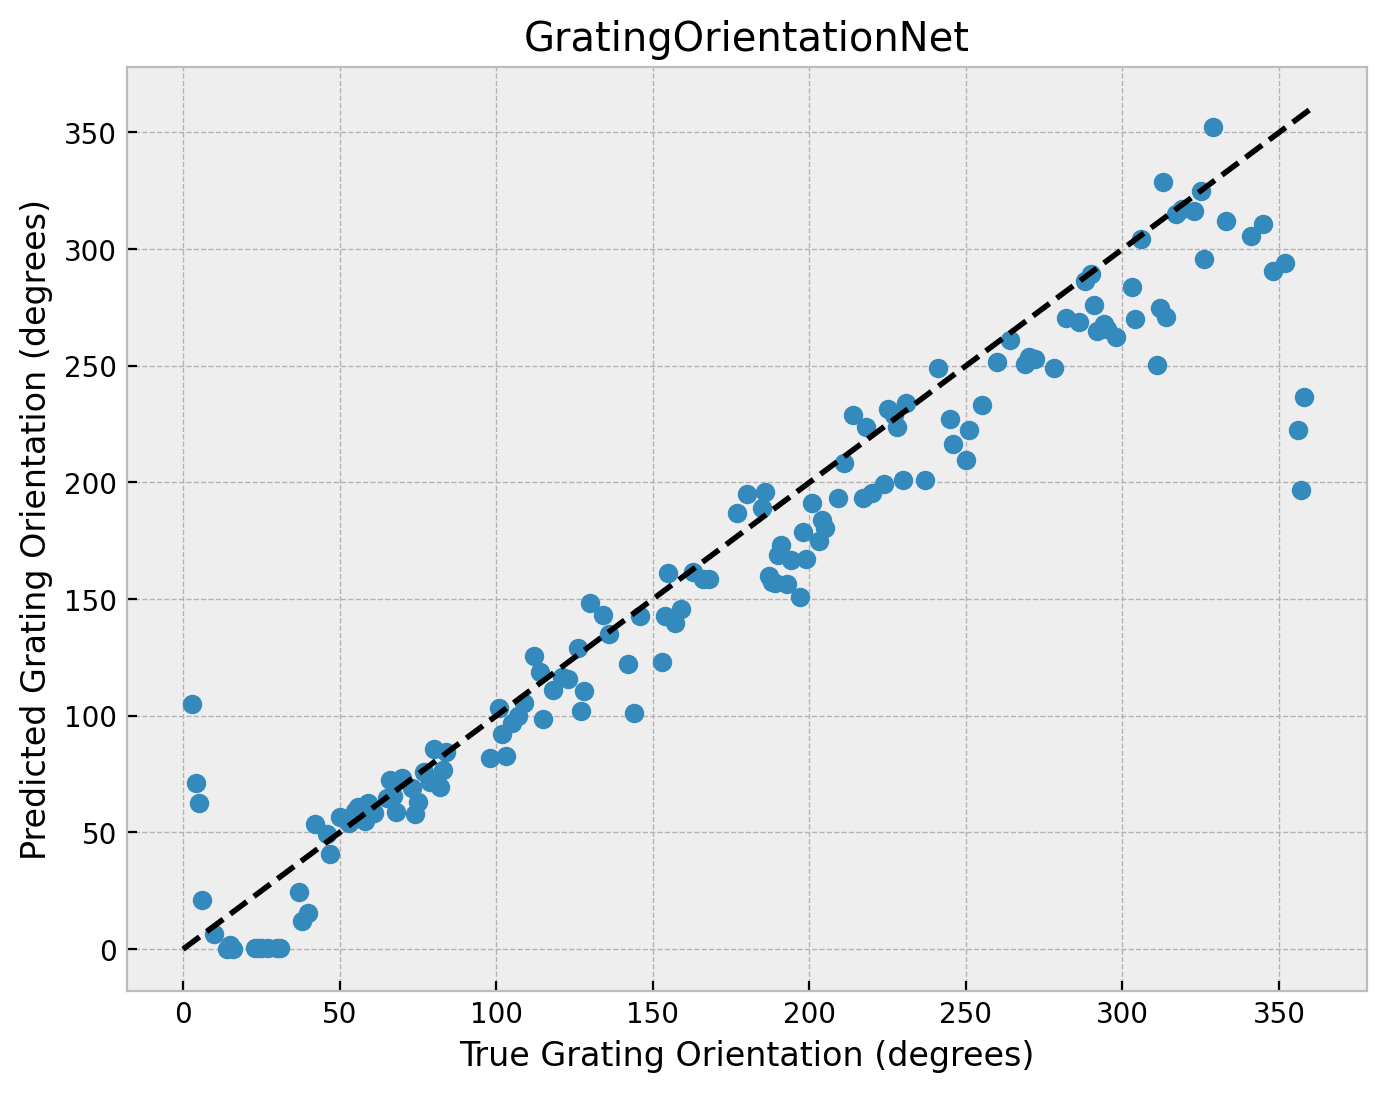

In [44]:
pred = grating_model(Xt_test)

pred_grating_orientations = pred.squeeze().detach().numpy()

plt.plot(y_test, pred_grating_orientations, 'o')
plt.plot([0, 360], [0, 360], 'k--')
plt.xlabel('True Grating Orientation (degrees)')
plt.ylabel('Predicted Grating Orientation (degrees)')
plt.title('GratingOrientationNet');

# Convolutional Neural Networks (CNNs)

In [ ]:
from IPython.display import Image
Image(url='https://miro.medium.com/max/790/1*1okwhewf5KCtIPaFib4XaA.gif')

In [45]:
# adapted from https://compneuro.neuromatch.io/tutorials/W2D1_DeepLearning/student/W2D1_Tutorial2.html#helper-functions
def make_filters(out_channels=6, K=7):
    """ make example filters, some center-surround and gabors
    Returns:
      filters: out_channels x K x K
    """
    grid = np.linspace(-K/2, K/2, K).astype(np.float32)
    xx,yy = np.meshgrid(grid, grid, indexing='ij')

    # create center-surround filters
    sigma = 1.1
    gaussian = np.exp(-(xx**2 + yy**2)**0.5/(2*sigma**2))
    wide_gaussian = np.exp(-(xx**2 + yy**2)**0.5/(2*(sigma*2)**2))
    center_surround = gaussian - 0.5 * wide_gaussian

    # create gabor filters
    thetas = np.linspace(0, 180, out_channels-2+1)[:-1] * np.pi/180
    gabors = np.zeros((len(thetas), K, K), np.float32)
    lam = 10
    phi = np.pi/2
    gaussian = np.exp(-(xx**2 + yy**2)**0.5/(2*(sigma*0.4)**2))
    for i,theta in enumerate(thetas):
        x = xx*np.cos(theta) + yy*np.sin(theta)
        gabors[i] = gaussian * np.cos(2*np.pi*x/lam + phi)

    filters = np.concatenate((center_surround[np.newaxis,:,:],
                            -1*center_surround[np.newaxis,:,:],
                            gabors),
                           axis=0)
    filters /= np.abs(filters).max(axis=(1,2))[:,np.newaxis,np.newaxis]
    filters -= filters.mean(axis=(1,2))[:,np.newaxis,np.newaxis]
    # convert to torch
    filters = torch.from_numpy(filters)
    # add channel axis
    filters = filters.unsqueeze(1)

    return filters

In [46]:
filters = make_filters(out_channels=6, K=7)

filters.shape

torch.Size([6, 1, 7, 7])

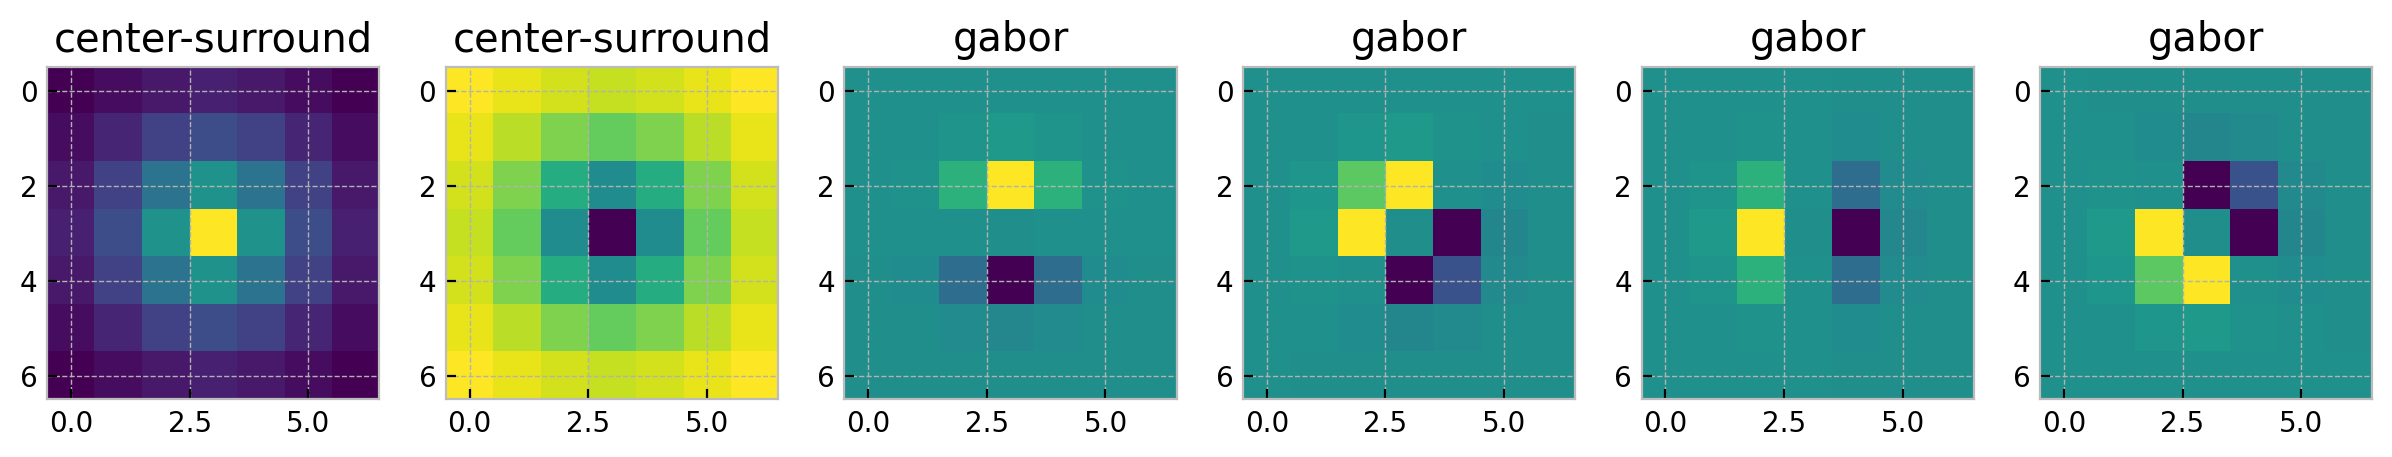

In [47]:
plt.figure(figsize=[15,4])
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(filters[i,0,:,:])
    if i < 2:
        plt.title('center-surround')
    else:
        plt.title('gabor')

In [48]:
# adapted from https://compneuro.neuromatch.io/tutorials/W2D1_DeepLearning/student/W2D1_Tutorial2.html#helper-functions
def make_grating(angle, sf=1 / 28, res=0.1, patch=False):
    """Generate oriented grating stimulus

    Args:
    angle (float): orientation of grating (angle from vertical), in degrees
    sf (float): controls spatial frequency of the grating
    res (float): resolution of image. Smaller values will make the image
      smaller in terms of pixels. res=1.0 corresponds to 640 x 480 pixels.
    patch (boolean): set to True to make the grating a localized
      patch on the left side of the image. If False, then the
      grating occupies the full image.

    Returns:
    torch.Tensor: (res * 480) x (res * 640) pixel oriented grating image

    """

    angle = np.deg2rad(angle)  # transform to radians

    wpix, hpix = 640, 480  # width and height of image in pixels for res=1.0

    xx, yy = np.meshgrid(sf * np.arange(0, wpix * res) / res, sf * np.arange(0, hpix * res) / res)

    if patch:
        gratings = np.cos(xx * np.cos(angle + .1) + yy * np.sin(angle + .1))  # phase shift to make it better fit within patch
        gratings[gratings < 0] = 0
        gratings[gratings > 0] = 1
        xcent = gratings.shape[1] * .75
        ycent = gratings.shape[0] / 2
        xxc, yyc = np.meshgrid(np.arange(0, gratings.shape[1]), np.arange(0, gratings.shape[0]))
        icirc = ((xxc - xcent) ** 2 + (yyc - ycent) ** 2) ** 0.5 < wpix / 3 / 2 * res
        gratings[~icirc] = 0.5
    else:
        gratings = np.cos(xx * np.cos(angle) + yy * np.sin(angle))
        gratings[gratings < 0] = 0
        gratings[gratings > 0] = 1

    gratings -= 0.5

    # Return torch tensor
    return torch.tensor(gratings, dtype=torch.float32)

Stimuli

![](images/grating-orientations.png)

In [50]:
orientations = [-90, -45, 0, 45, 90]
stimuli = torch.zeros((len(orientations), 1, 48, 64), dtype=torch.float32)
for i, ori in enumerate(orientations):
    stimuli[i,0,:,:] = make_grating(ori)

stimuli.shape

torch.Size([5, 1, 48, 64])

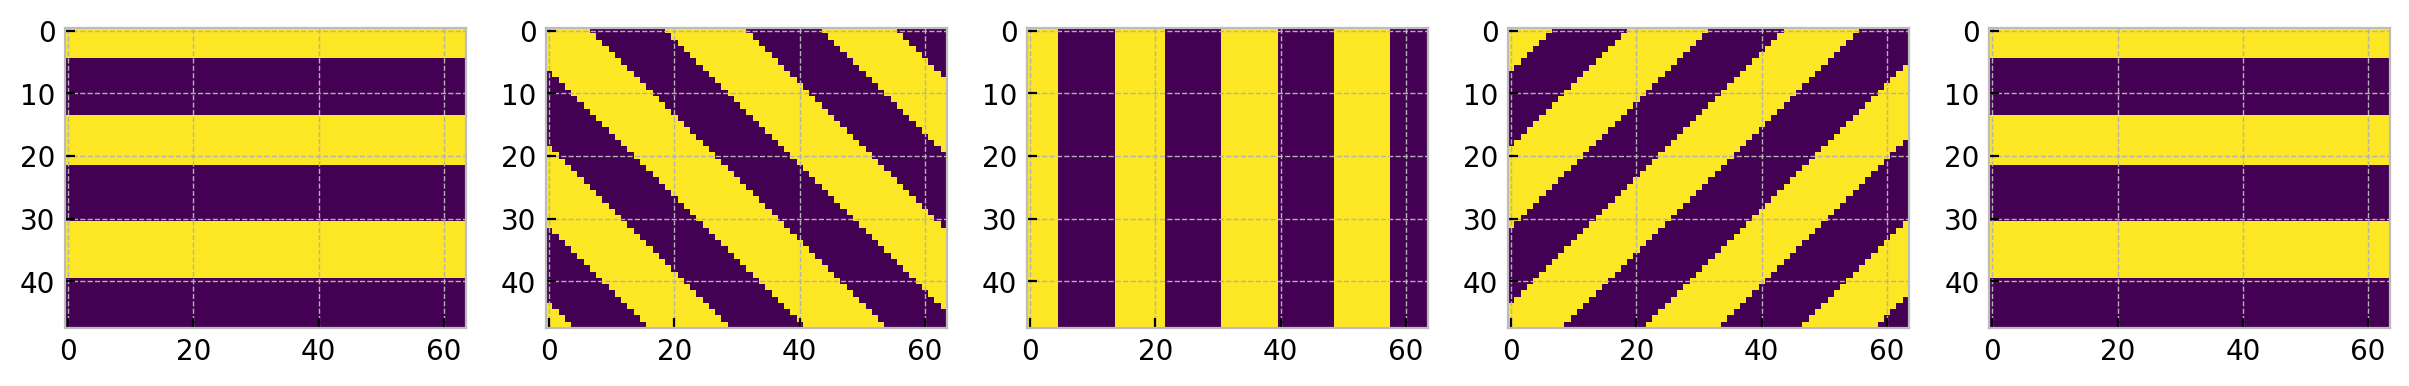

In [51]:
plt.figure(figsize=[15,5])
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(stimuli[i,0,:,:])

In [53]:
orientations = np.arange(360)
stimuli = torch.zeros((len(orientations), 1, 48, 64), dtype=torch.float32)
for i, ori in enumerate(orientations):
    stimuli[i,0,:,:] = make_grating(ori)

stimuli.shape

torch.Size([360, 1, 48, 64])

In [54]:
stimuli.shape, filters.shape

(torch.Size([360, 1, 48, 64]), torch.Size([6, 1, 7, 7]))

Try this convolutional neural network...

![](images/conv-fc-net.png)

In [55]:
class GratingLeftRightTiltNet(nn.Module):
    def __init__(self):
        # initialize parent class
        nn.Module.__init__(self)
        
        # convolutional layer
        # add padding to ensure that each channel has same dimensionality as input
        self.conv = nn.Conv2d(1, 6, kernel_size=7, padding=3)
        
        # init convolutional kernels to center-surround and gabor filters
        self.conv.weight = nn.Parameter(filters)
        self.conv.bias = nn.Parameter(torch.zeros((6,), dtype=torch.float32))
        
        # fully connected layer with 10 neurons
        self.fc = nn.Linear(6 * 48 * 64, 10)
        
        # output layer with single neuron (will decide left or right tilt)
        self.out = nn.Linear(10, 1)

    def forward(self, images_in):
        # images_in:  n_stimuli x 1  x h x w
        # images_out: n_stimuli x 6 x h x w
        images_out = self.conv(images_in)
        
        # each row of X is the flattened output from the convolutional layer
        # for one stimulus image
        X = images_out.reshape(-1, 6 * 48 * 64)
        
        # h: length 10 output of fully connected layer
        X = torch.relu(self.fc(X))
        
        # network output with sigmoid for binary choice
        y = torch.sigmoid(self.out(X))
        
        return y

In [56]:
# for reproducibility
torch.manual_seed(1)

# create model
model = GratingLeftRightTiltNet()

# forward pass for unoptimized model
output = model(stimuli)

output.shape

torch.Size([360, 1])

In [57]:
output = output.squeeze().detach().numpy()
choice = (output >= 0.5)

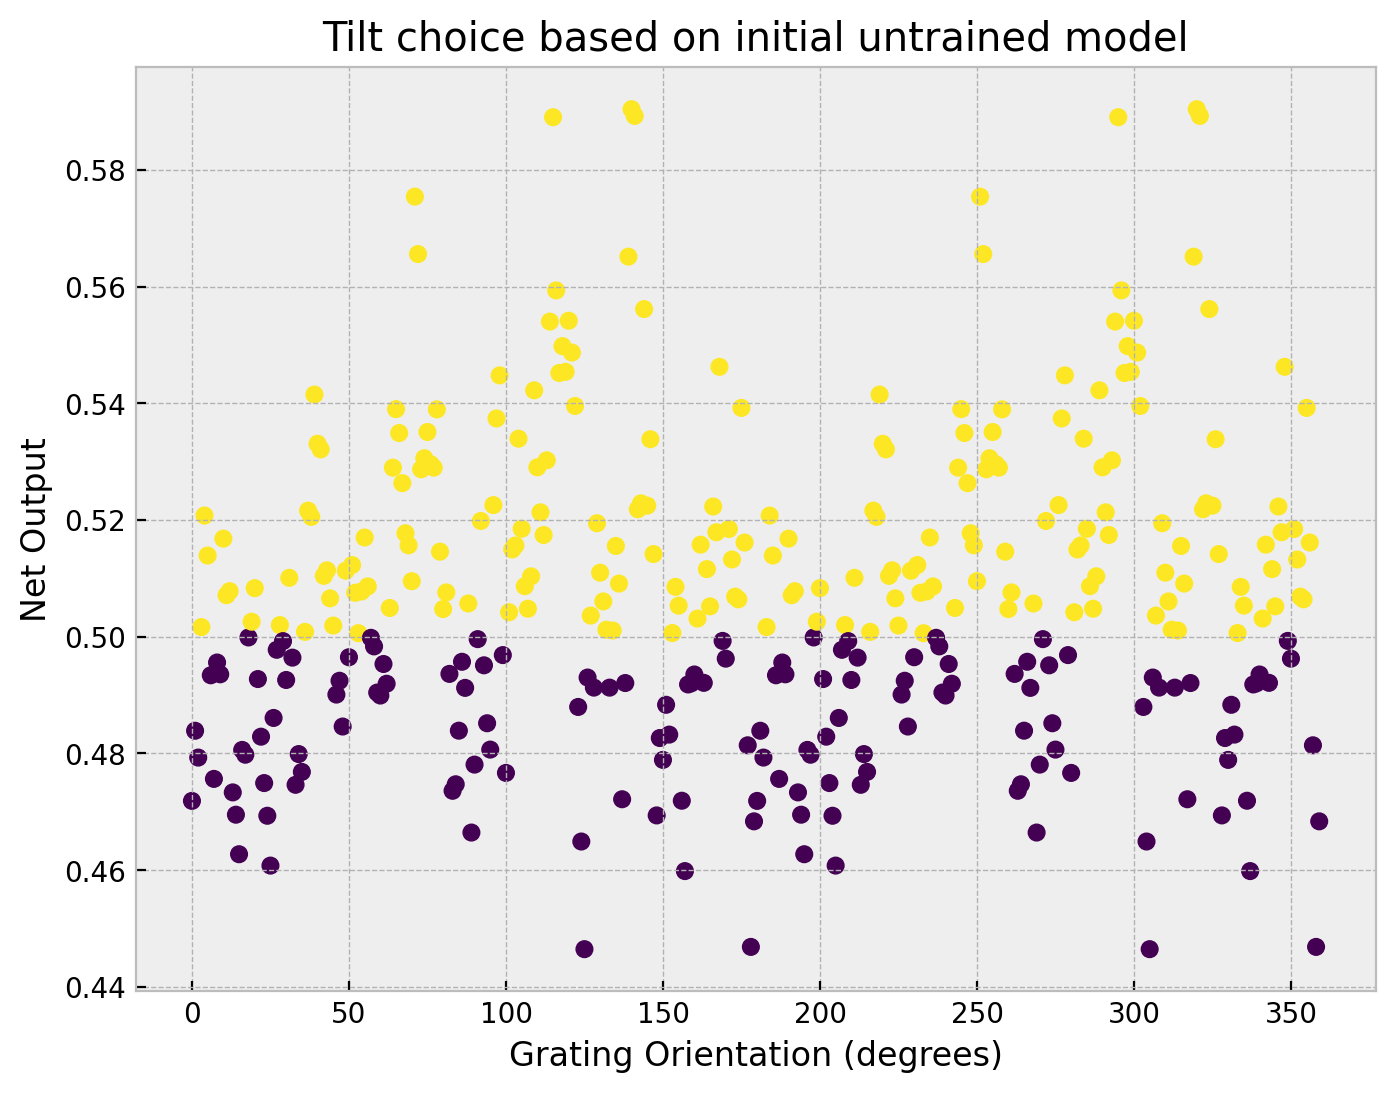

In [59]:
plt.scatter(range(360), output, c=choice)
plt.xlabel('Grating Orientation (degrees)')
plt.ylabel('Net Output')
plt.title('Tilt choice based on initial untrained model');

In [60]:
# loss function
loss_fn = nn.MSELoss()

# stochastic gradient descent optimizer
# lr = learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

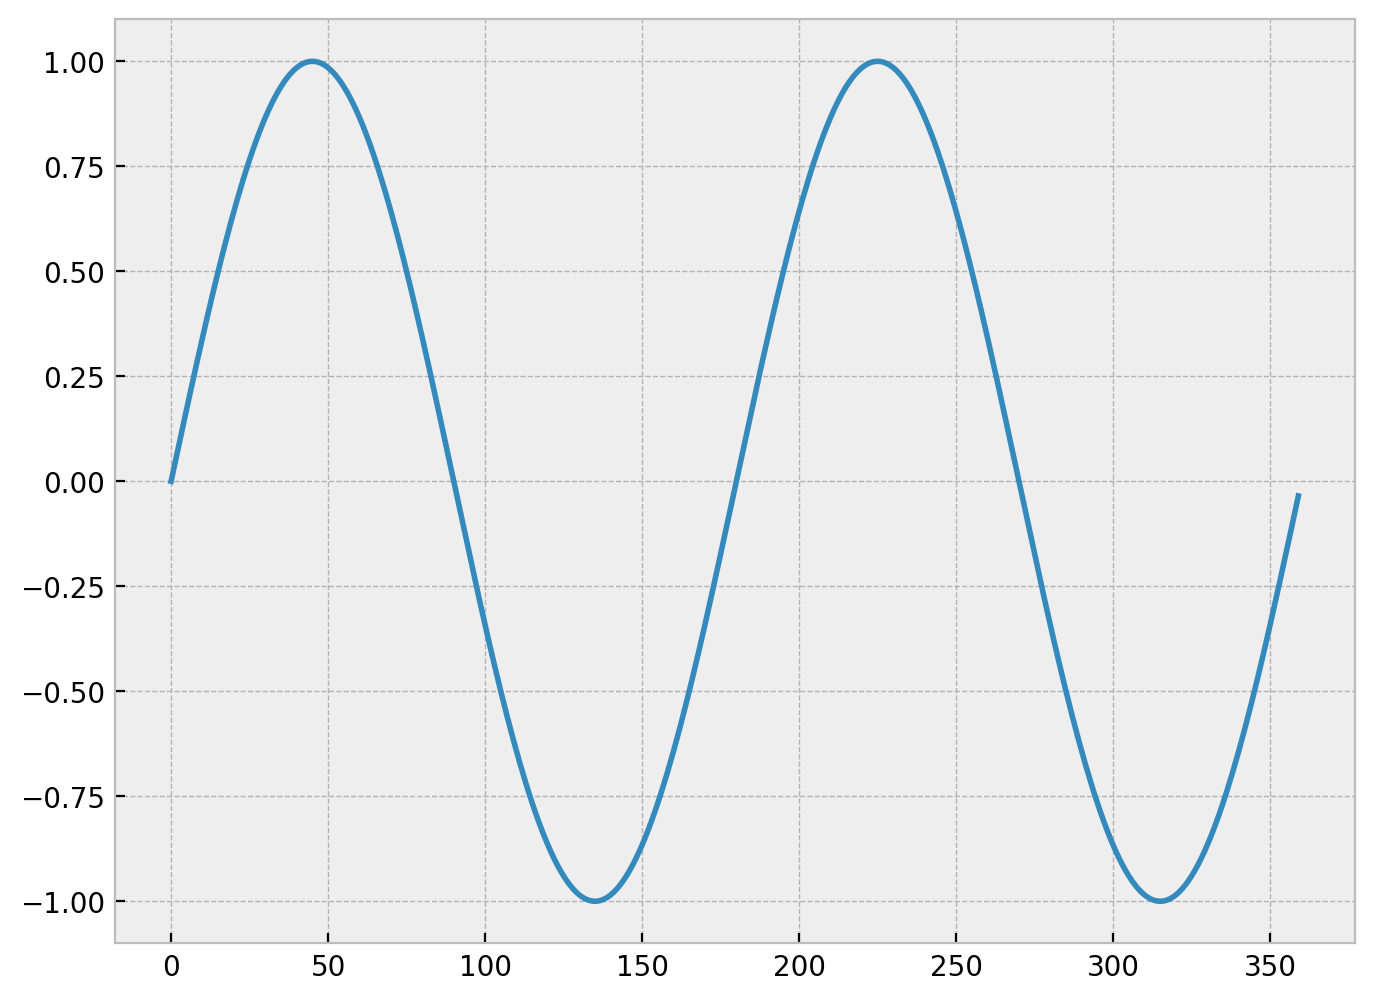

In [61]:
orientations = np.arange(360)
y = np.sin(orientations * np.pi / 180 * 2)

plt.plot(np.arange(360), y);

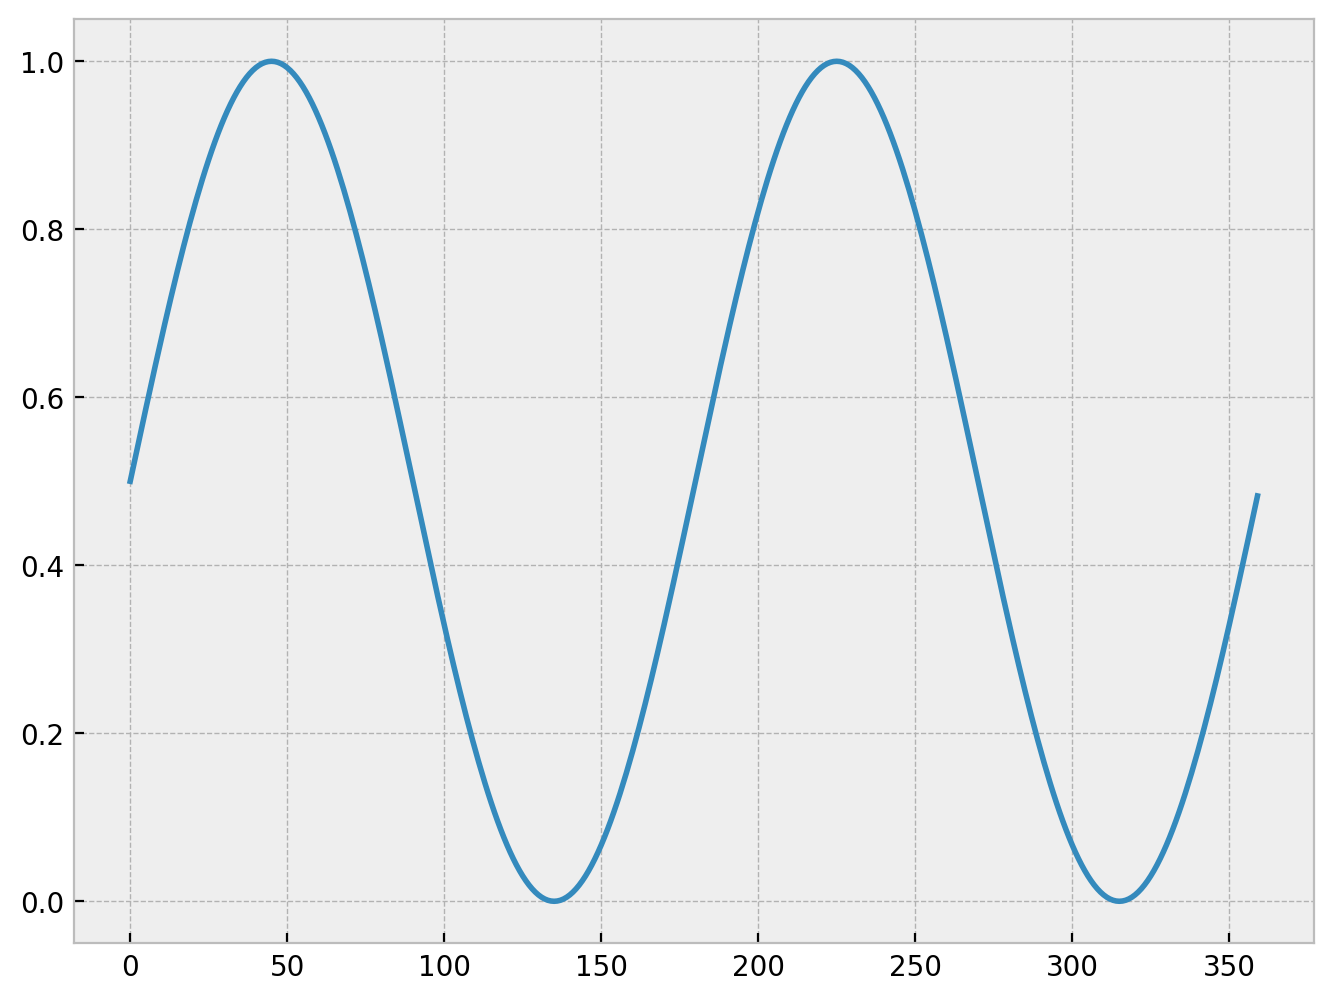

In [62]:
y = y / 2 + 0.5

plt.plot(np.arange(360), y);

In [63]:
y = torch.tensor(y.reshape(-1,1)).float()

stimuli.shape, y.shape

(torch.Size([360, 1, 48, 64]), torch.Size([360, 1]))

In [64]:
# warning: this may take several minutes to run
train_loss = train(model, stimuli, y, loss_fn, optimizer, 300)

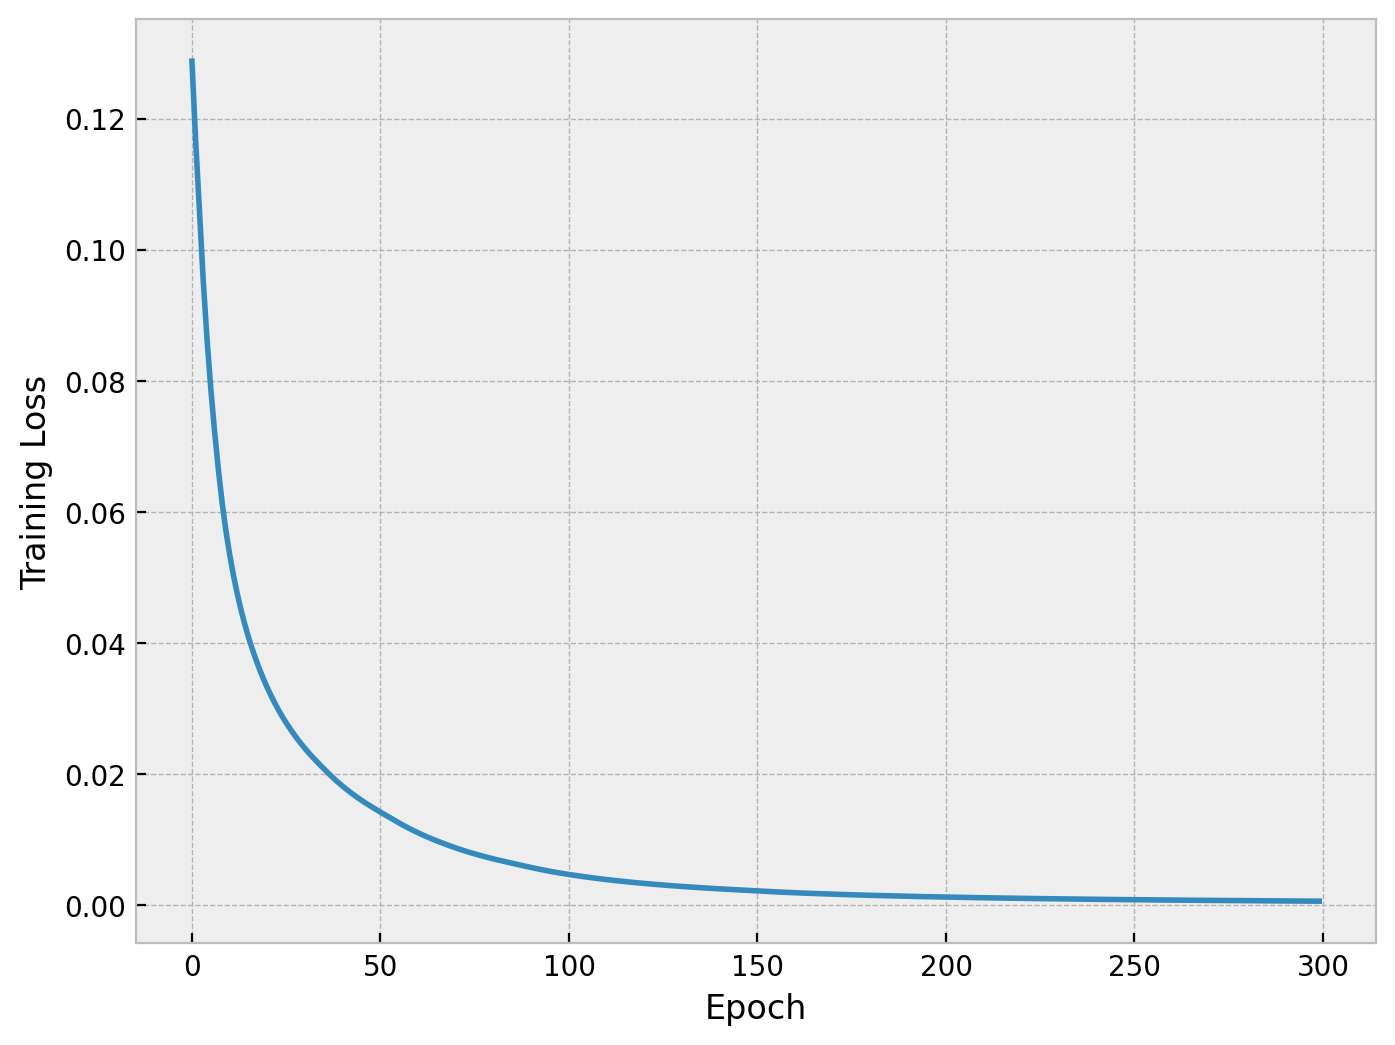

In [65]:
plt.plot(train_loss)
plt.xlabel('Epoch')
plt.ylabel('Training Loss');

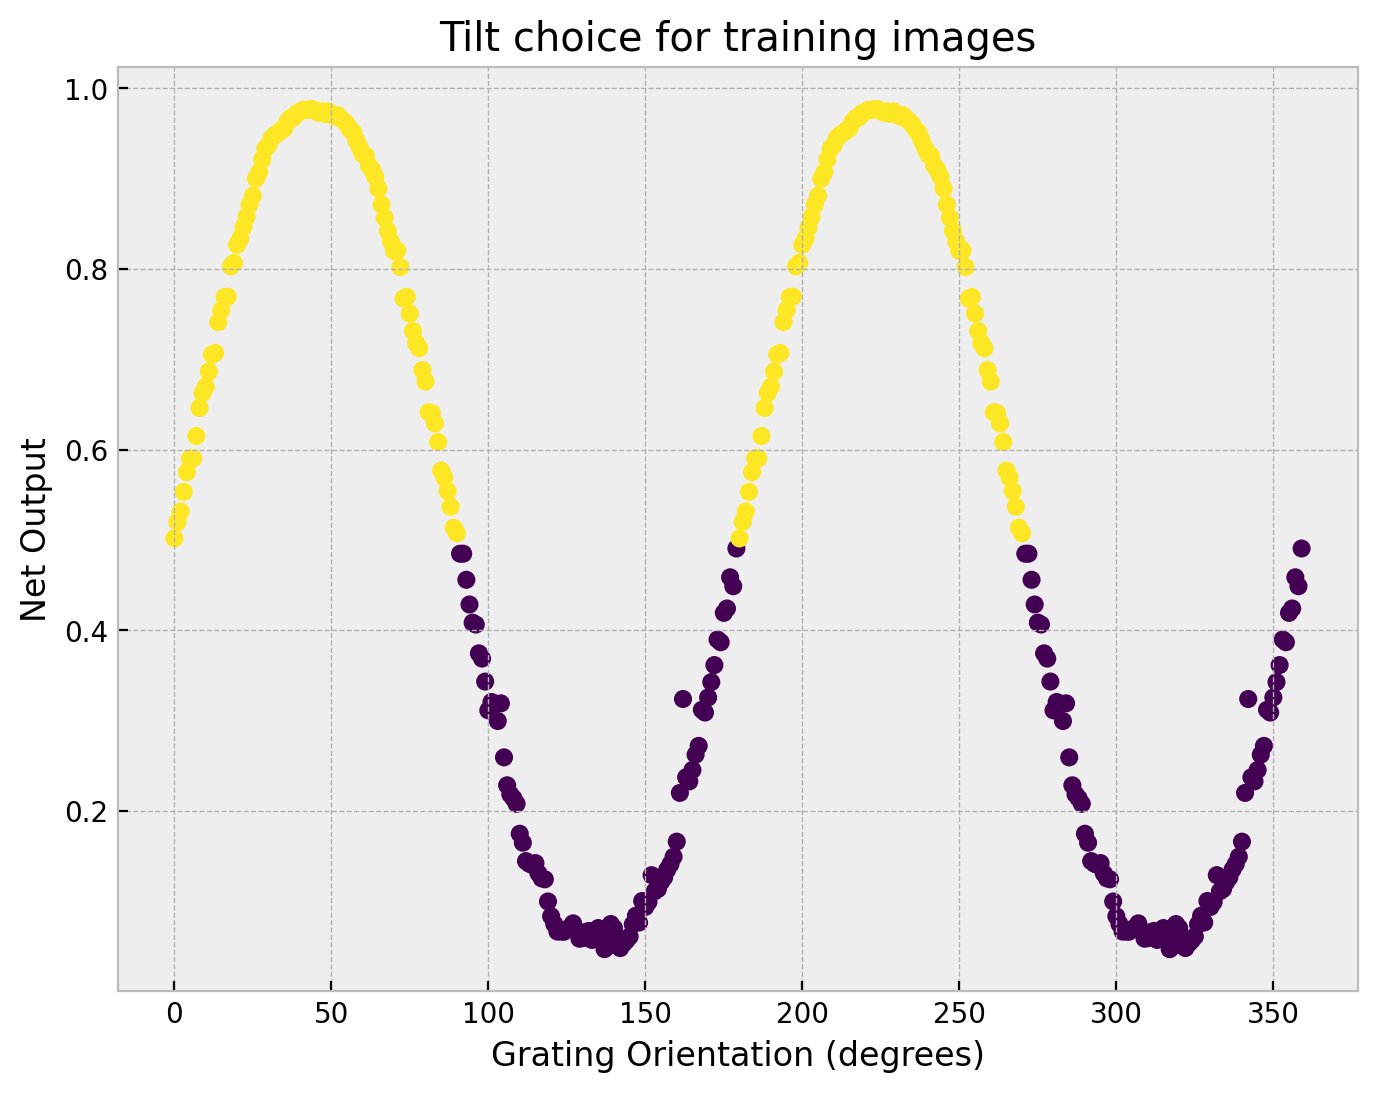

In [66]:
y_pred = model(stimuli)

y_pred = y_pred.squeeze().detach()

choice = (y_pred >= 0.5)

plt.scatter(orientations, y_pred, c=choice)
plt.xlabel('Grating Orientation (degrees)')
plt.ylabel('Net Output')
plt.title('Tilt choice for training images');

In [67]:
test_orientations = np.random.random(1000) * 360

test_orientations[:5]

array([333.97361433, 208.98455414, 186.88243878, 211.53768899,
        82.3571813 ])

In [68]:
test_stimuli = torch.zeros((len(test_orientations), 1, 48, 64), dtype=torch.float32)
for i, ori in enumerate(test_orientations):
    test_stimuli[i,0,:,:] = make_grating(ori)

test_stimuli.shape

torch.Size([1000, 1, 48, 64])

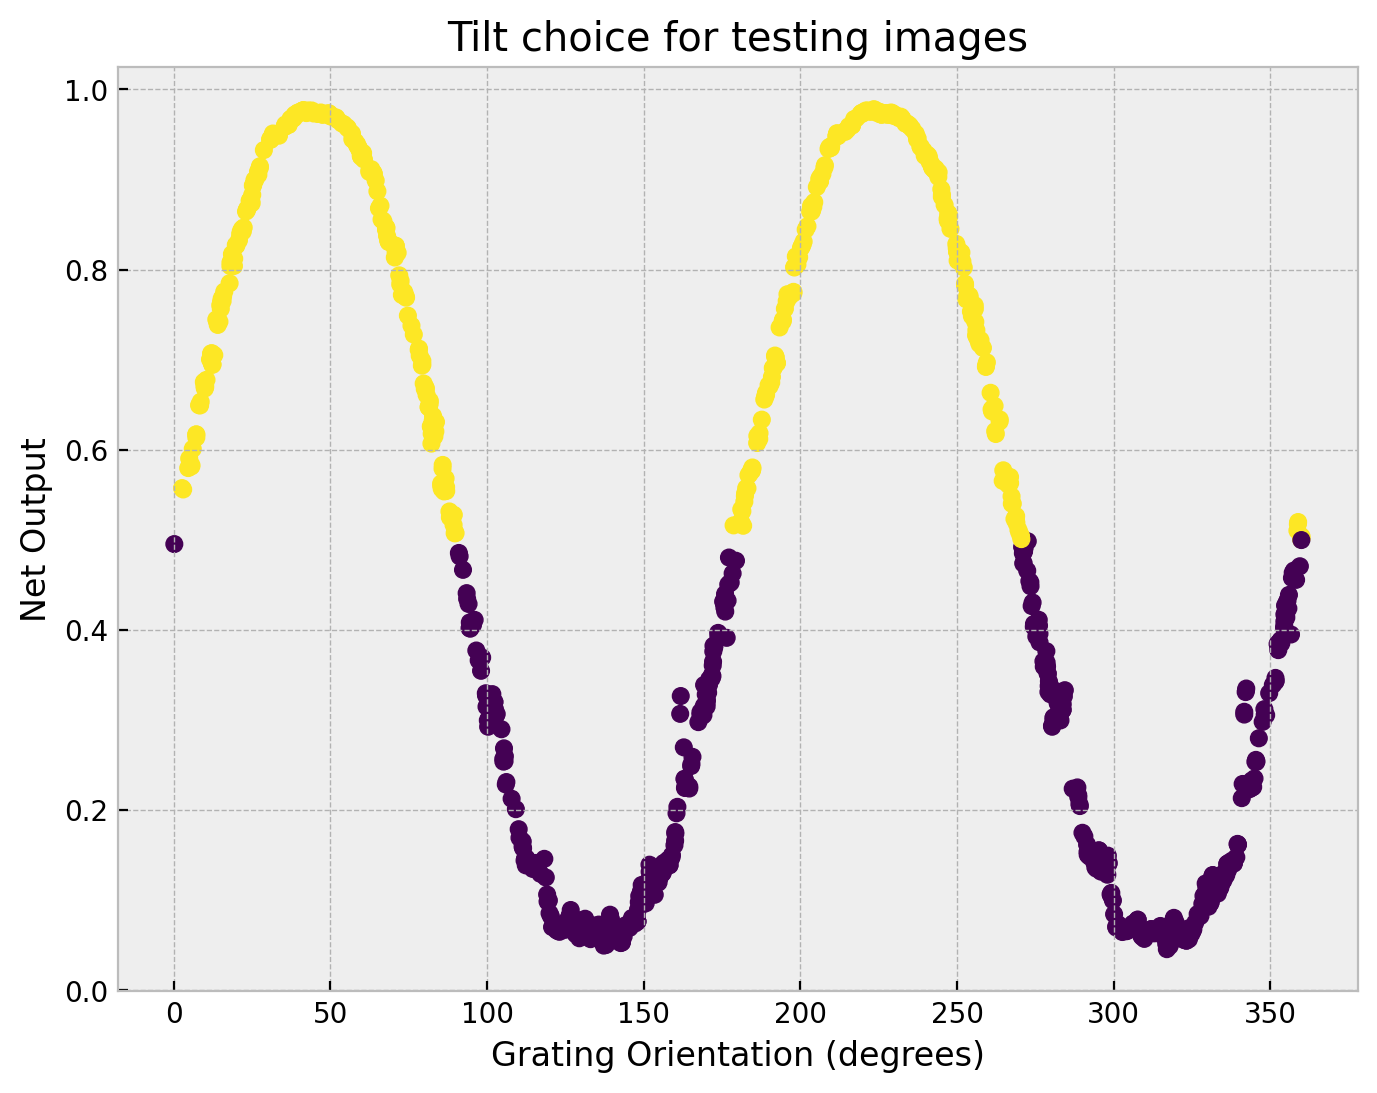

In [69]:
y_pred = model(test_stimuli)

y_pred = y_pred.squeeze().detach()

choice = (y_pred >= 0.5)

plt.scatter(test_orientations, y_pred, c=choice)
plt.xlabel('Grating Orientation (degrees)')
plt.ylabel('Net Output')
plt.title('Tilt choice for testing images');

### Learning goals - *Neural Network*
|  |  |  |
|--|--|--|
| <img src="images/thinking-icon.png"> | <div class="alert alert-info">You will be introduced to PyTorch for building and training neural networks.</div> | `e.g.` |